In [ ]:
import pandas as pd
import re
from tqdm.auto import tqdm
from statistics import mean
from sklearn.utils import shuffle
from google.colab import drive


drive.mount('/content/drive/')

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc


sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 12, 8

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# BeerAdvocate parser

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
links = {}
url = f'https://www.beeradvocate.com/beer/styles/'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')
divs = soup.find_all('div', class_='stylebreak')
for div in divs:
  group_name = div.find_all('b')[0].text
  lis = div.find_all('li')
  for li in lis:
    token = li.find_all('a', href=True)[0]
    link = f"https://www.beeradvocate.com{token['href']}"
    name = token.text

    links[name] = [link, group_name]

In [ ]:
full_information = []

for beer_type in tqdm(links, total=len(links)): # all beer types

  for page in [0, 50, 100, 150]:
    url = f"{links[beer_type][0]}?sort=revsD&start={page}"
    group_name = links[beer_type][1]
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    tds = soup.find_all('td', class_='hr_bottom_light')

    for i in range(len(tds)): # all beers of choosen type
      if i%6 == 0:
        company = tds[i].find_all('a')[1].text
        name = tds[i].find_all('a')[0].text

        profile_link = f"https://www.beeradvocate.com{tds[i].find_all('a')[0]['href']}"
        resp = requests.get(profile_link)
        s = BeautifulSoup(resp.text, 'lxml')

        info = {} # all current beer info

        info['Name:'] = name 
        info['Group:'] = group_name

        dl = s.find_all('dl', class_='beerstats')[0]
        dts = dl.find_all('dt') 
        dds = dl.find_all('dd')

        for i in range(len(dts)):
          col = dts[i].text

          if i == 1:
            col = 'Region:'

          t = re.sub('\n|\xa0', '', dds[i].text)
          t = re.sub('Ranked \#[0-9,]+$', '', t)
          info[col] = t

        all_com_info = []
        all_rate_info = []

        comments = s.find_all('div', class_='user-comment')

        for comm in comments: # all comment for current beer
          rate = comm.find_all('span', class_='BAscore_norm')

          if rate:          
            text_review = comm.find_all('div', style="margin:20px 0px; font-size:11pt; line-height:1.4;")[0].text

            all_com_info.append(text_review)
            all_rate_info.append(rate[0].text)

        info['Reviews:'] = all_com_info
        info['Rates:'] = all_rate_info
        full_information.append(info)


  0%|          | 0/120 [00:00<?, ?it/s]

## Extending dataframe

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/nnlp_project/beer_df_large.csv', sep='\t', encoding='utf-8')

In [ ]:
to_append = {}

for g in df['Group'].unique():
  len_g = df[df.Group == g].Style.unique()
  print(f'Group: {g}, n_Styles: {len(len_g)}, n_tokens {round(9000/len(len_g))}')
  print('N tokens to append per style:')
  for s in len_g:
    len_s = len(df[df.Style == s])
    if len_s < round(9000/len(len_g)):
      to_append[s] = [round(10000/len(len_g))-len_s, round(9000/len(len_g))]
      print(f'Style: {s}, n2append: {round(9000/len(len_g))-len_s}')
  print('\n')

Group: Bocks, n_Styles: 5, n_tokens 1800
N tokens to append per style:
Style: Bock, n2append: 22
Style: Eisbock, n2append: 1575
Style: Maibock, n2append: 178
Style: Weizenbock, n2append: 1106


Group: Brown Ales, n_Styles: 5, n_tokens 1800
N tokens to append per style:
Style: Altbier, n2append: 368
Style: Belgian Dark Ale, n2append: 1062
Style: English Dark Mild Ale, n2append: 853


Group: Dark Ales, n_Styles: 4, n_tokens 2250
N tokens to append per style:
Style: Dubbel, n2append: 692
Style: Roggenbier, n2append: 2060
Style: Scottish Ale, n2append: 1049
Style: Winter Warmer, n2append: 40


Group: Dark Lagers, n_Styles: 9, n_tokens 1000
N tokens to append per style:
Style: Czech Amber Lager, n2append: 794
Style: Czech Dark Lager, n2append: 142
Style: Rauchbier, n2append: 201


Group: India Pale Ales, n_Styles: 8, n_tokens 1125
N tokens to append per style:
Style: Brut IPA, n2append: 568


Group: Pale Ales, n_Styles: 14, n_tokens 643
N tokens to append per style:
Style: English Pale Mild

In [ ]:
full_information = []

for beer_type in tqdm(links, total=len(links)): # all beer types
  if beer_type in to_append:
    n2append = to_append[beer_type][0]
    n_appended = 0
    for page in [200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]:
      url = f"{links[beer_type][0]}?sort=revsD&start={page}"
      group_name = links[beer_type][1]
      response = requests.get(url)
      soup = BeautifulSoup(response.text, 'lxml')
      tds = soup.find_all('td', class_='hr_bottom_light')

      for i in range(len(tds)): # all beers of choosen type
        if i%6 == 0:
          company = tds[i].find_all('a')[1].text
          name = tds[i].find_all('a')[0].text

          profile_link = f"https://www.beeradvocate.com{tds[i].find_all('a')[0]['href']}"
          resp = requests.get(profile_link)
          s = BeautifulSoup(resp.text, 'lxml')

          info = {} # all current beer info

          info['Name:'] = name 
          info['Group:'] = group_name

          dl = s.find_all('dl', class_='beerstats')[0]
          dts = dl.find_all('dt') 
          dds = dl.find_all('dd')

          for i in range(len(dts)):
            col = dts[i].text

            if i == 1:
              col = 'Region:'

            t = re.sub('\n|\xa0', '', dds[i].text)
            t = re.sub('Ranked \#[0-9,]+$', '', t)
            info[col] = t

          all_com_info = []
          all_rate_info = []

          comments = s.find_all('div', class_='user-comment')

          for comm in comments: # all comment for current beer
            rate = comm.find_all('span', class_='BAscore_norm')

            if rate:          
              text_review = comm.find_all('div', style="margin:20px 0px; font-size:11pt; line-height:1.4;")[0].text

              all_com_info.append(text_review)
              all_rate_info.append(rate[0].text)

          n_appended += len(all_com_info)
          info['Reviews:'] = all_com_info
          info['Rates:'] = all_rate_info
          full_information.append(info)
      print(f'Style: {beer_type}, Appended: {n_appended}/{n2append}')
      if n_appended >= n2append:
        break

## Save data

In [ ]:
data = {k:[] for k in full_information[0].keys()}

for beer in full_information:
  for i in range(len(beer['Reviews:'])):
    ks = beer.keys()
    for k in ks:
      if k != 'Reviews:' and k != 'Rates:':
        data[k].append(beer[k])
    data['Reviews:'].append(beer['Reviews:'][i])
    data['Rates:'].append(beer['Rates:'][i])


In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df = df[['Name:', 'From:', 'Group:', 'Region:', 'Style:', 'ABV:', 'Avg:', 'Reviews:', 'Rates:']]

In [ ]:
df.rename(columns={'From:':'Company',
                   'Name:':'Name',
                   'Group:':'Group',
                   'Region:':'Region',
                   'Style:':'Style',
                   'ABV:':'ABV',
                   'Avg:':'Avg',
                   'Reviews:':'Review',
                   'Rates':'Rate'}, inplace=True)

In [ ]:
df.Avg = df.Avg.map(lambda x: re.sub(' \| .*$', '', x))

In [ ]:
df.to_csv('/content/drive/MyDrive/nnlp_project/beer_df_large.csv', sep='\t', encoding='utf-8', index=False)

# EDA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/nnlp_project/beer_df_large.csv', sep='\t', encoding='utf-8')

print(f"Shape: {df.shape}\nColumns: {', '.join(df.columns.to_list())}")

Shape: (174684, 9)
Columns: Name, Company, Group, Region, Style, ABV, Avg, Review, Rate


In [ ]:
df.head(2)

,Name,Company,Group,Region,Style,ABV,Avg,Review,Rate
0,Shiner Bock,Spoetzl Brewery,Bocks,"Texas, United States",Bock,4.5%,3.21,From a 12oz bottle into a cocktail glass.\n\nC...,3.66
1,Shiner Bock,Spoetzl Brewery,Bocks,"Texas, United States",Bock,4.5%,3.21,"Great relaxing beer. Very mellow, great taste-...",4.10


In [ ]:
df = df[df.Review.notna()]

In [ ]:
df['Group'].value_counts()

Pale Lagers        26816
Pale Ales          23130
Strong Ales        20756
Stouts             16864
India Pale Ales    14274
Wild/Sour Beers    13347
Dark Lagers        12356
Specialty Beers    12349
Porters             9524
Wheat Beers         8536
Brown Ales          7494
Bocks               6362
Dark Ales           5159
Name: Group, dtype: int64

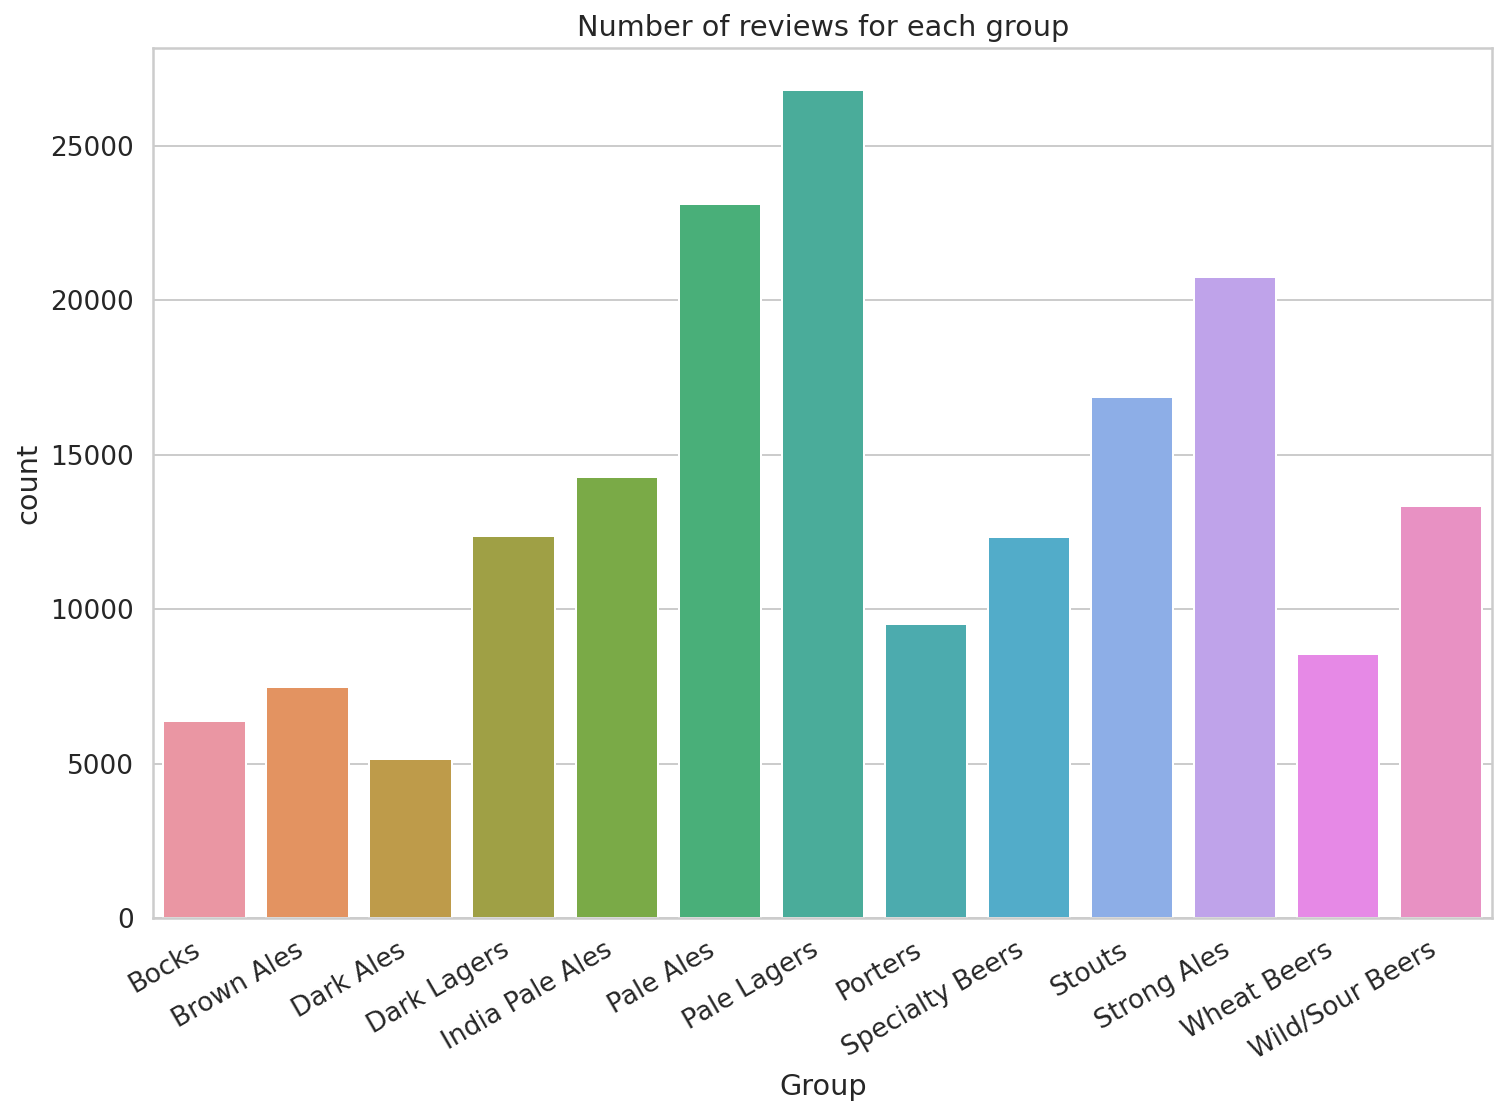

In [ ]:
chart = sns.countplot(x=df.Group)
plt.title("Number of reviews for each group")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

## Balanced dataframe

In [ ]:
sampled = pd.DataFrame()
max_len = 10000

for name, i in df.Group.value_counts().iteritems():
    if i > max_len:
        temp_df = df[df.Group == name]
        min_l = round(10000/len(temp_df.Style.unique()))
        for s in temp_df.Style:
          if len(temp_df[temp_df.Style == s]) > min_l:
            st_df = temp_df[temp_df.Style == s]
            temp_df = temp_df[temp_df.Style != s]
            st_df = st_df.iloc[0:min_l]
            temp_df = temp_df.append(st_df)
        sampled = sampled.append(temp_df)
    else:
        sampled = sampled.append(df[df.Group == name])

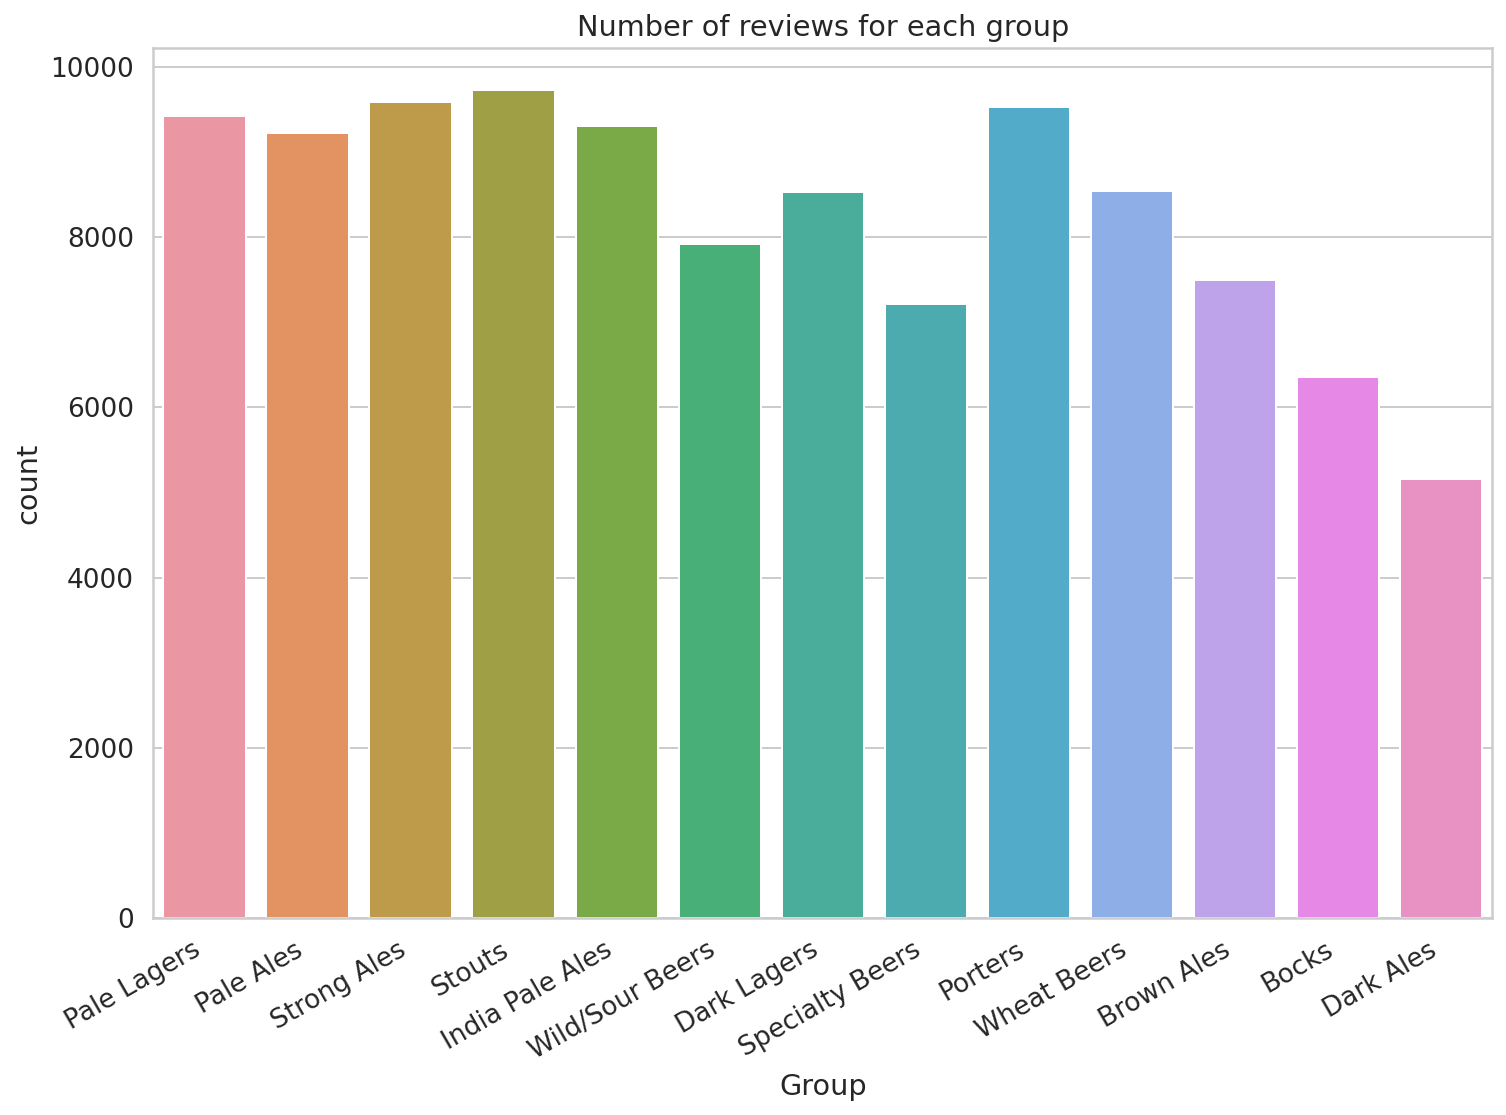

In [ ]:
chart = sns.countplot(x=sampled.Group)
plt.title("Number of reviews for each group")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [ ]:
sampled.head()

,Name,Company,Group,Region,Style,ABV,Avg,Review,Rate
75412,Staropramen Lager,Pivovary Staropramen,Pale Lagers,Czechia,Czech Pale Lager,5%,3.36,"Much better than Staropramen světlý, even thou...",4.02
75413,Staropramen Lager,Pivovary Staropramen,Pale Lagers,Czechia,Czech Pale Lager,5%,3.36,"Look:- Brown-gold ,thick head and light carbon...",3.91
75414,Staropramen Lager,Pivovary Staropramen,Pale Lagers,Czechia,Czech Pale Lager,5%,3.36,I tried a 0.33L bottle of this beer at a resta...,3.66
75415,Staropramen Lager,Pivovary Staropramen,Pale Lagers,Czechia,Czech Pale Lager,5%,3.36,"Clear, pale gold appearance, average size whit...",3.41
75416,Staropramen Lager,Pivovary Staropramen,Pale Lagers,Czechia,Czech Pale Lager,5%,3.36,Light brown body with fast dissipating head. (...,3.52


In [ ]:
gr, mean_l = [], []
for g in sampled.Group.unique():
  mean_l.append(mean(df[df.Group==g].Review.map(lambda x: len(str(x)))))
  gr.append(g)

<Axes: xlabel='Group', ylabel='Mean review length'>

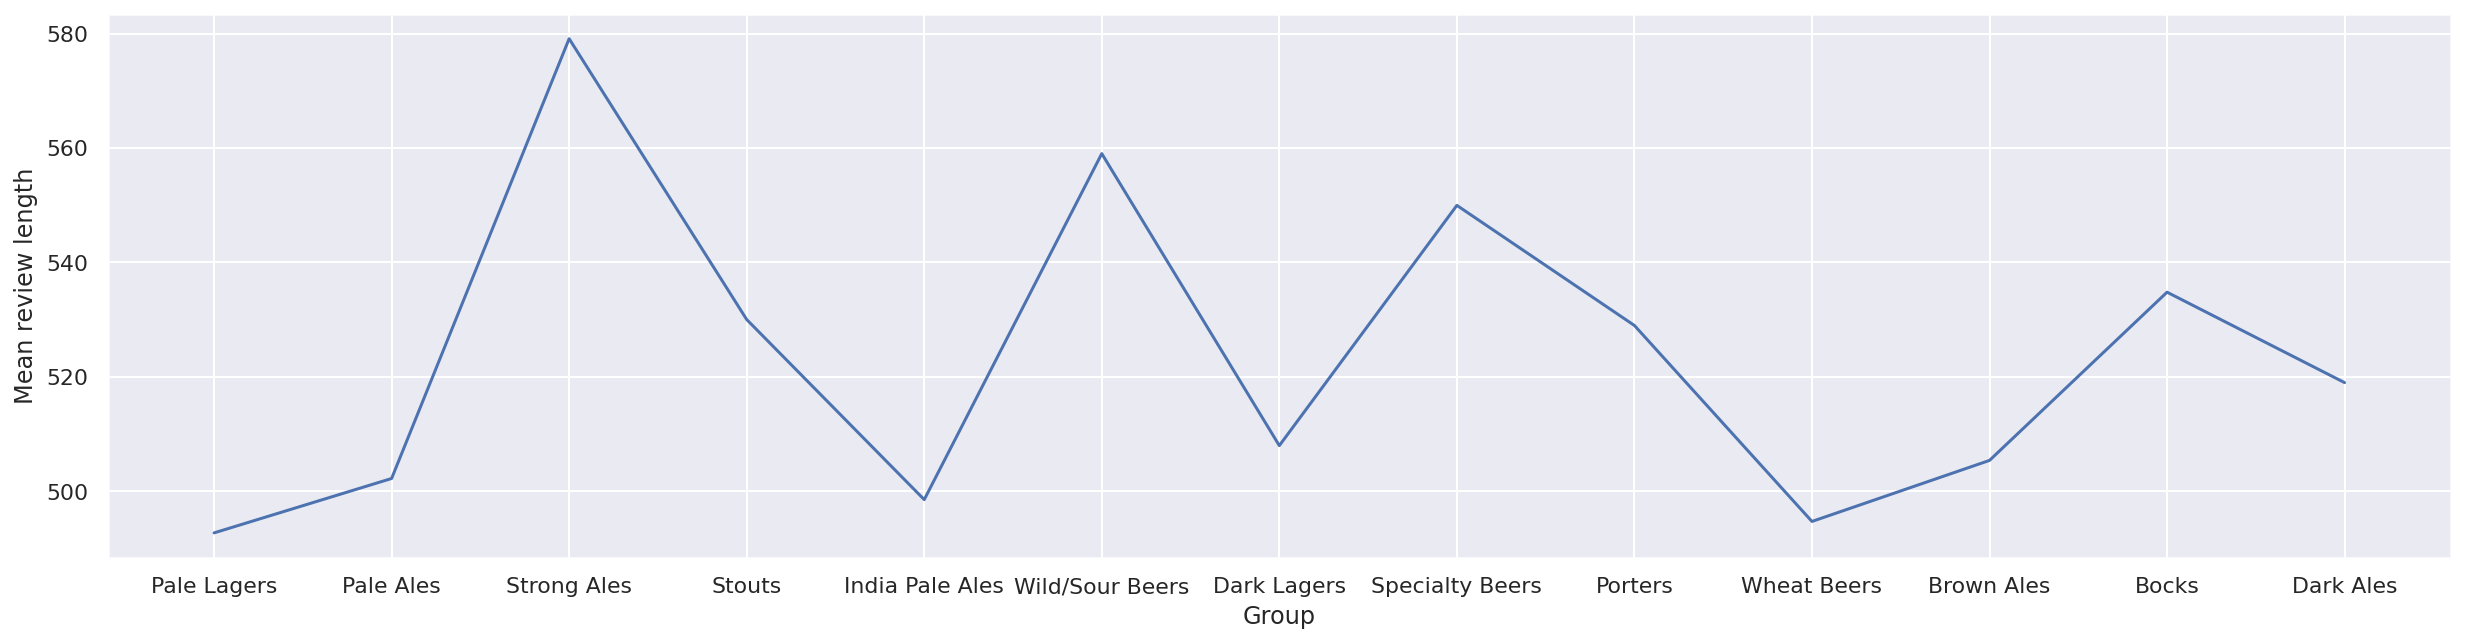

In [ ]:
sns.set(rc={'figure.figsize':(21,5)})

sns.lineplot(
    x='Group', 
    y='Mean review length',
    data=pd.DataFrame({'Group': gr, 'Mean review length': mean_l}))

In [ ]:
print(f"Средняя длина отзыва: {round(mean(sampled.Review.map(lambda x: len(str(x)))))} символа или {round(mean(sampled.Review.map(lambda x: len(str(x).split(' ')))))} слов")

Средняя длина отзыва: 518 символа или 89 слов


In [ ]:
sampled.to_csv('/content/drive/MyDrive/nnlp_project/beer_df_norm.csv', sep='\t', encoding='utf-8', index=False)

In [ ]:
for g in sampled['Group'].unique():
  len_g = sampled[sampled.Group == g].Style.unique()
  print(f'Group: {g}, n_Styles: {len(len_g)}, mean_tokens {round(10000/len(len_g))}')
  print('N tokens to append per style:')
  for s in len_g:
    len_s = len(sampled[sampled.Style == s])
    print(f'Style: {s}, n: {len_s}')
  print('\n')

Group: Pale Lagers, n_Styles: 15, mean_tokens 667
N tokens to append per style:
Style: Czech Pale Lager, n: 332
Style: Imperial Pilsner, n: 419
Style: American Adjunct Lager, n: 667
Style: American Lager, n: 667
Style: Bohemian / Czech Pilsner, n: 667
Style: European / Dortmunder Export Lager, n: 667
Style: European Pale Lager, n: 667
Style: European Strong Lager, n: 667
Style: Festbier / Wiesnbier, n: 667
Style: German Pilsner, n: 667
Style: Helles, n: 667
Style: India Pale Lager (IPL), n: 667
Style: Kellerbier / Zwickelbier, n: 667
Style: Light Lager, n: 667
Style: Malt Liquor, n: 667


Group: Pale Ales, n_Styles: 14, mean_tokens 714
N tokens to append per style:
Style: English Pale Mild Ale, n: 274
Style: Grisette, n: 378
Style: American Amber / Red Ale, n: 714
Style: American Blonde Ale, n: 714
Style: American Pale Ale, n: 714
Style: Belgian Blonde Ale, n: 714
Style: Belgian Pale Ale, n: 714
Style: Bière de Garde, n: 714
Style: English Bitter, n: 714
Style: English Pale Ale, n: 714